# QTM350 Project: Predicting the number of COVID-19 cases for California and New York

## Members: Shinyoung Kang, Sunny Chung

Covid-19 has become a pandemic disease that has led many countries around the globe for a shutdown. While some countries are starting to open up, we are still unsure as to when the crisis may end. We expect that coronavirus will have at least two big waves where number of cases drastically increase and decrease because of the nature of pandemic disease. With the use of current data collected from johns Hopkins university on number of cases, we attempt to answer when the crisis may end, at least for the first wave of crisis. We use nonlinear regression to fit a model, predicting when the first wave may end, potentially expect when would be the most appropriate time to go out.

## Data Collection, Preparation, and Feature Engineering

We decided to use open data lake from AWS to pull specifically the number of cases confirmed from United States only. We used AWS CLI to pull publicly available S3 bucket called covid19-lake, where they have variety of data related to coronavirus. Our ETL (Extract, Transform, Load) process simply collects the data on all the cases in United States, then extract just the ones for New York and California, where the number of coronavirus is the highest.

We first download the COVID-19 data from AWS

In [1]:
!aws s3 ls s3://covid19-lake --no-sign-request

                           PRE alleninstitute/
                           PRE cfn/
                           PRE covid_knowledge_graph/
                           PRE covidcast/
                           PRE enigma-jhu-timeseries/
                           PRE enigma-jhu/
                           PRE enigma-nytimes-data-in-usa/
                           PRE rearc-covid-19-nyt-data-in-usa/
                           PRE rearc-covid-19-prediction-models/
                           PRE rearc-covid-19-testing-data/
                           PRE rearc-usa-hospital-beds/
                           PRE safegraph-open-census-data/
                           PRE static-datasets/
                           PRE tableau-jhu/
2020-04-09 16:03:39       9328 dashboard.html
2020-04-07 06:22:16      23116 databrowser.html
2020-04-07 06:35:31      23116 index.html


In [5]:
!aws s3 cp s3://covid19-lake/rearc-covid-19-nyt-data-in-usa/csv/us-states/us-states.csv . --no-sign-request

download: s3://covid19-lake/rearc-covid-19-nyt-data-in-usa/csv/us-states/us-states.csv to ./us-states.csv


Then we read the csv file using `pd.read_csv()`

In [7]:
# importing pandas as pd 
import pandas as pd 
  
# Creating the dataframe  
df = pd.read_csv("us-states.csv") 
  
# Look at the dataframe 
df.describe()

In order to start ordering the data, we first group the data by states since we want to know the cases for each state.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# applying groupby() function to 
data = df.groupby('state')

Then we create a separate COVID-19 variable for California and New York using `get_group()`

In [49]:
covidcali = data.get_group('California')
covidny = data.get_group('New York')

Since cases go up to a high number we will also look at logged cases.

In [245]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

covidcali['logcases'] = np.log10(covidcali['cases'])
covidny['logcases'] = np.log10(covidny['cases'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Since indexing is different for California and New York, we want to create another variable that will have the index starting as 1 as Day one.

In [242]:
# Using DataFrame.insert() to add a column 
covidcali['newindex'] = range(1, len(covidcali) + 1)
covidny['newindex'] = range(1, len(covidny) + 1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Explore data a little bit by checking the number of rows and columns in our data using `shape()`

In [212]:
covidcali.shape

(98, 7)

In [211]:
covidny.shape

(62, 6)

Using `describe()` we can look at the mean, std, percentiles of the varaibles of the data

In [243]:
covidcali.describe()

,fips,cases,deaths,newindex,logcases
count,98.0,98.000000,98.000000,98.000000,98.000000
mean,6.0,9931.693878,341.122449,49.500000,2.564156
std,0.0,15253.997432,587.397217,28.434134,1.584257
min,6.0,1.000000,0.000000,1.000000,0.000000
25%,6.0,7.000000,0.000000,25.250000,0.845098
50%,6.0,350.500000,5.000000,49.500000,2.543037
75%,6.0,17226.000000,431.750000,73.750000,4.235962
max,6.0,52318.000000,2147.000000,98.000000,4.718651


In [244]:
covidny.describe()

,fips,cases,deaths,newindex,logcases
count,62.0,62.000000,62.000000,62.000000,62.000000
mean,36.0,112973.564516,5735.209677,31.500000,4.143196
std,0.0,111337.500597,6735.724682,18.041619,1.564312
min,36.0,1.000000,0.000000,1.000000,0.000000
25%,36.0,1056.000000,11.750000,16.250000,3.017789
50%,36.0,79860.500000,1745.500000,31.500000,4.901779
75%,36.0,220157.750000,12040.500000,46.750000,5.342672
max,36.0,308345.000000,18610.000000,62.000000,5.489037


Now, we reshape the data using `reshape(1, -1)` to get a 1D array

In [246]:
X = covidcali["newindex"].values.reshape(1,-1)
Y = covidcali["cases"].values.reshape(1,-1)
X1 = covidcali["newindex"].values.reshape(1,-1)
Y1 = covidcali["logcases"].values.reshape(1,-1)

In [247]:
X2 = covidny["newindex"].values.reshape(1,-1)
Y2 = covidny["cases"].values.reshape(1,-1)
X3 = covidny["newindex"].values.reshape(1,-1)
Y3 = covidny["logcases"].values.reshape(1,-1)

## Looking at graphs to see how linear regression fits

Lets first take a look at linear regresion of California

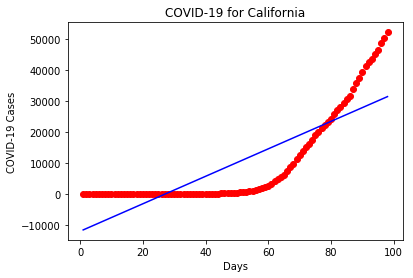

In [248]:
# Fitting Linear Regression to the logged dataset 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X, Y) 
m, b = np.polyfit(X[0], lin_reg.predict(X)[0], 1) 
a = m*X + b
# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X, Y, color='red')
    plt.plot(X, lin_reg.predict(X), color='blue')
    plt.plot(X[0][:],a[0], color = 'blue')        #####Calculating will give Best line of Fit
    plt.title('COVID-19 for California')
    plt.xlabel('Days')
    plt.ylabel('COVID-19 Cases')
    plt.show()
    return
viz_linear()

On the 100th day from the beginning the prediction will be that there are `100*m + b` number of cases on the "m th" day.

In [227]:
100*m+b

32385.5356425607

Expected number of 32386 people infected.

Similarly, now lets take a look at New York

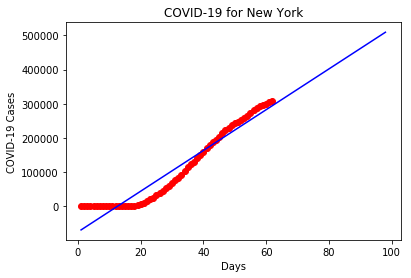

In [259]:
# Fitting Linear Regression to the logged dataset 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X2, Y2) 
m, b = np.polyfit(X2[0], lin_reg.predict(X2)[0], 1) 
a = m*X + b
# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X2, Y2, color='red')
    plt.plot(X2, lin_reg.predict(X2), color='blue')
    plt.plot(X[0][:],a[0], color = 'blue')        #####Calculating will give Best line of Fit
    plt.title('COVID-19 for New York')
    plt.xlabel('Days')
    plt.ylabel('COVID-19 Cases')
    plt.show()
    return
viz_linear()

In [260]:
70*m+b

342186.93900934263

On the 70th day, New York will have an estimated number of 342187 cases of COVID-19.

## Looking at Logged Cases

Lets now take a quick look at the logged cases for California and New York

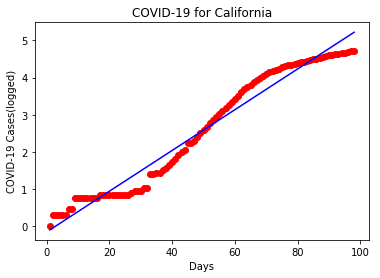

In [262]:
# Fitting Linear Regression to the logged dataset 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X1, Y1) 
m, b = np.polyfit(X1[0], lin_reg.predict(X1)[0], 1) 
a = m*X + b
# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X1, Y1, color='red')
    plt.plot(X1, lin_reg.predict(X1), color='blue')
    plt.plot(X[0][:],a[0], color = 'blue')        #####Calculating will give Best line of Fit
    plt.title('COVID-19 for California')
    plt.xlabel('Days')
    plt.ylabel('COVID-19 Cases(logged)')
    plt.show()
    return
viz_linear()

On the 100th day from the beginning the prediction will be that there are 10 to the logged predicted value

In [251]:
10**(m*100+b)

213812.85663244087

Although it seems as if the data shows a closer answer to the COVID-19 cases than normal regression, the logged cases gives a difference in about "0.5" which is equivalent to 3 times the value.

Here is a quick example of comparing the actual and predicted values. THey are very close as you can see there is almost minimal difference among the actual and predicted.

In [264]:
df = pd.DataFrame({'Actual': Y1[0], 'Predicted': a[0]})
df

,Actual,Predicted
0,0.000000,-0.092181
1,0.301030,-0.037411
2,0.301030,0.017359
3,0.301030,0.072128
4,0.301030,0.126898
5,0.301030,0.181668
6,0.477121,0.236438
7,0.477121,0.291208
8,0.778151,0.345978
9,0.778151,0.400748


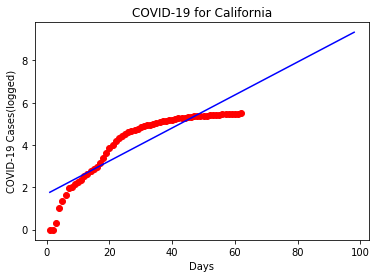

In [266]:
# Fitting Linear Regression to the logged dataset 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X3, Y3) 
m, b = np.polyfit(X3[0], lin_reg.predict(X3)[0], 1) 
a = m*X + b
# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X3, Y3, color='red')
    plt.plot(X3, lin_reg.predict(X3), color='blue')
    plt.plot(X[0][:],a[0], color = 'blue')        #####Calculating will give Best line of Fit
    plt.title('COVID-19 for California')
    plt.xlabel('Days')
    plt.ylabel('COVID-19 Cases(logged)')
    plt.show()
    return
viz_linear()

Predicted COVID cases for the 70th day in New York

In [253]:
10**(m*70+b)

13973017.278746817

Although it seems as if the data shows a closer answer to the COVID-19 cases than normal regression, the logged cases gives a difference in about "1" which is equivalent to 10 times the value.

We took a look over how we can use linear regression to actively measure the "n"th day after COVID-19 recording started. Gaining more data and using different regression models can improve the predicted values. Acknowledging how the future can be is critical in a sense that we know how dangerous COVID can be outside. With current data, it seems as if COVID will only increase in the next few month if there are no strict laws or medicine for COVID-19.